# Parameter sweep for LBI predictor

Load flu tip attributes and final clade frequencies and then calculate the error of an exponential growth model based on just the LBI predictor across a range of predictor coefficients. The goal is to determine the shape of the error function that is exposed to scipy's optimization machinery.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

plt.style.use("huddlej")

In [2]:
pwd

'/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses'

In [3]:
sys.path.insert(0, "../src")

In [20]:
from fit_model import DistanceExponentialGrowthModel, sum_of_differences
from weighted_distances import get_distances_by_sample_names

## Load data

Define the range of possible coefficient values to explore.

In [66]:
coefficients = np.linspace(-15, 15, 31)

In [43]:
delta_time = 1.0
l1_lambda = 0.0

In [44]:
last_timepoint = pd.to_datetime("2016-10-01")

In [45]:
distances = pd.read_csv(
    "../results/builds/h3n2/1_viruses_per_month/sample_0/2000-10-01--2015-10-01/target_distances.tsv",
    sep="\t"
)

In [46]:
distances_by_sample = get_distances_by_sample_names(distances)

In [47]:
# Load tip attributes.
X = pd.read_csv(
    "../results/builds/h3n2/1_viruses_per_month/sample_0/2000-10-01--2015-10-01/standardized_tip_attributes.tsv",
    sep="\t",
    parse_dates=["timepoint"]
)

In [48]:
X.columns

Index(['strain', 'branch_length', 'cTiter', 'cTiterSub', 'cTiterSub_x',
       'clade_membership', 'clock_length', 'country', 'country_entropy',
       'dTiter', 'dTiterSub', 'date', 'delta_frequency', 'dms_star', 'ep',
       'ep_x', 'lbi', 'mutation_length', 'ne', 'ne_star', 'numdate',
       'raw_date', 'rb', 'region', 'region_entropy', 'is_terminal',
       'timepoint', 'lineage', 'segment', 'frequency', 'naive',
       'weighted_distance_to_future', 'weighted_distance_to_present',
       'log2_distance_effect'],
      dtype='object')

In [49]:
X = X.loc[:, ["strain", "clade_membership", "timepoint", "cTiterSub_x", "lbi", "ep", "ep_x", "ne", "delta_frequency", "frequency",
              "weighted_distance_to_present", "weighted_distance_to_future"]].copy()

In [50]:
X = X[X["timepoint"] <= last_timepoint]

In [51]:
X.head()

,strain,clade_membership,timepoint,cTiterSub_x,lbi,ep,ep_x,ne,delta_frequency,frequency,weighted_distance_to_present,weighted_distance_to_future
0,A/California/7/2004,4ff1302,2004-10-01,0.815847,1.983446,1.681531,1.817003,7,1.080522,0.063517,6.124823,5.887278
1,A/Canterbury/201/2004,4ff1302,2004-10-01,0.815847,1.983446,0.123254,0.869821,8,1.080522,0.063517,4.492171,4.176117
2,A/Canterbury/23/2004,4ff1302,2004-10-01,0.815847,2.312820,0.123254,0.869821,7,1.080522,0.085993,3.619208,3.176116
3,A/England/909/2003,b32cea9,2004-10-01,0.815847,-0.772716,-1.435024,-0.189384,6,-0.287716,0.000009,6.270080,8.603379
4,A/Hanoi/HN30147/2004,4ff1302,2004-10-01,0.815847,-0.881800,-0.396172,0.536196,7,1.080522,0.003242,5.923253,7.640958


In [52]:
X.shape

(1502, 12)

In [53]:
X = X[~pd.isnull(X["weighted_distance_to_present"])].copy()

In [54]:
X.shape

(1306, 12)

In [55]:
X["y"] = X["frequency"] * X["weighted_distance_to_future"]
y = X.loc[:, ["strain", "timepoint", "y"]].copy()

In [56]:
y.head()

,strain,timepoint,y
0,A/California/7/2004,2004-10-01,0.373942
1,A/Canterbury/201/2004,2004-10-01,0.265254
2,A/Canterbury/23/2004,2004-10-01,0.273124
3,A/England/909/2003,2004-10-01,0.000077
4,A/Hanoi/HN30147/2004,2004-10-01,0.024772


## Inspect LBI model

Text(0,0.5,'Weighted distance')

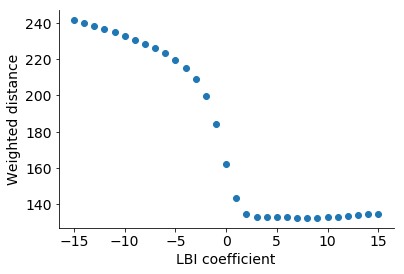

In [70]:
predictors = ["lbi"]
l1_lambda = 0.5
model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("Weighted distance")

In [71]:
min(errors)

132.54406728423817

In [72]:
coefficients[np.argmin(errors)]

8.0

## Inspect cTiterSub model

Text(0,0.5,'Weighted distance')

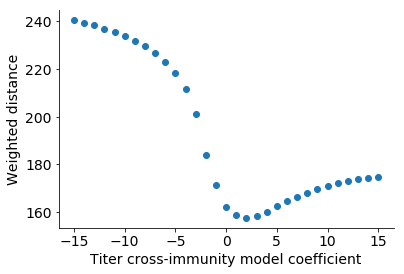

In [73]:
predictors = ["cTiterSub_x"]

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Titer cross-immunity model coefficient")
plt.ylabel("Weighted distance")

In [74]:
min(errors)

157.55524347599896

In [75]:
coefficients[np.argmin(errors)]

2.0

## Inspect epitope count model

Text(0,0.5,'Weighted distance')

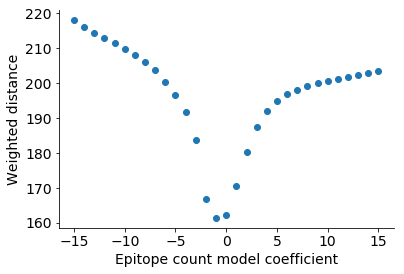

In [76]:
predictors = ["ep"]

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope count model coefficient")
plt.ylabel("Weighted distance")

In [ ]:
min(errors)

In [ ]:
coefficients[np.argmin(errors)]

## Inspect epitope cross-immunity model

Text(0,0.5,'Weighted distance')

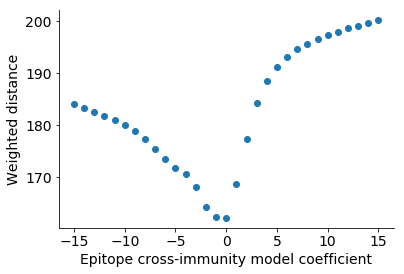

In [77]:
predictors = ["ep_x"]

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity model coefficient")
plt.ylabel("Weighted distance")

In [79]:
min(errors)

162.23064986189704

In [80]:
coefficients[np.argmin(errors)]

0.0

## Inspect delta frequency model

Text(0,0.5,'Weighted distance')

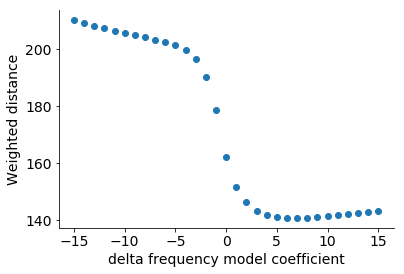

In [81]:
predictors = ["delta_frequency"]

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("delta frequency model coefficient")
plt.ylabel("Weighted distance")

In [82]:
min(errors)

140.69810743259626

In [83]:
coefficients[np.argmin(errors)]

7.0

## Inspect two-parameter models

In [84]:
predictors = ["lbi", "cTiterSub_x"]

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)

In [85]:
len(coefficients)

31

In [86]:
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
    
    errors_by_first_coefficient[coefficient_i] = errors

IndexError: index 24 is out of bounds for axis 0 with size 24

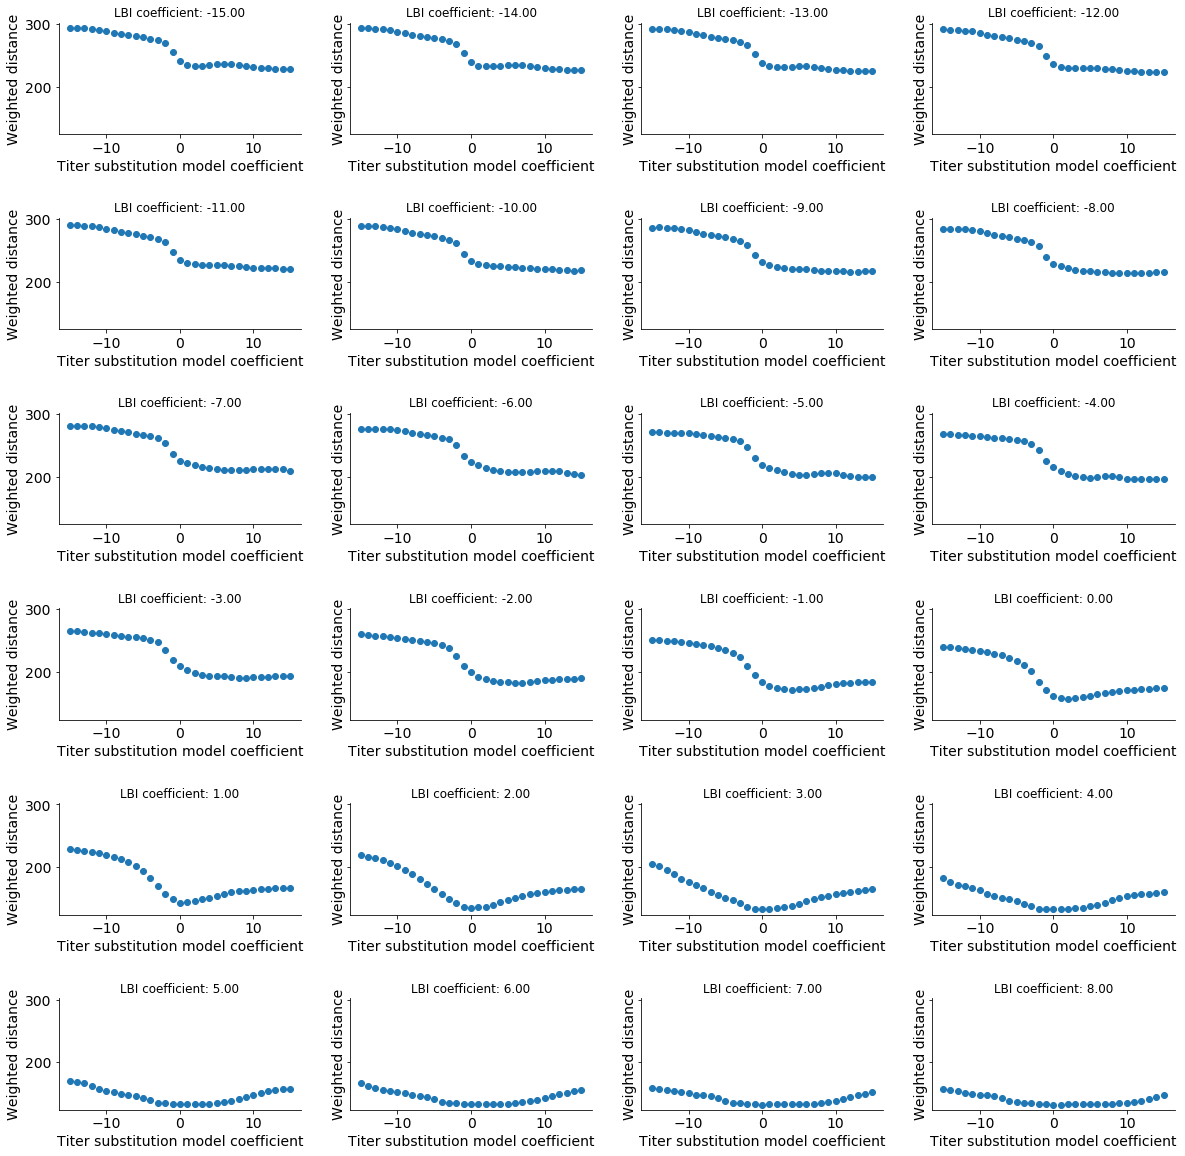

In [87]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("Weighted distance")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

In [ ]:
predictors = ["lbi", "cTiterSub_x"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

records = []
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
        records.append({
            "lbi": coefficient_i,
            "cTiterSub": coefficient_j,
            "error": error
        })
    
    errors_by_first_coefficient[coefficient_i] = errors

In [ ]:
records_df = pd.DataFrame(records)
records_df.sort_values("error").head()

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("MAE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)